In [1]:
%pylab inline
from scipy import interpolate
from scipy import optimize
import tqdm
import ipywidgets as ipw

Populating the interactive namespace from numpy and matplotlib


In [110]:
N = 15 # number of layers
nk = 200 # number of k points
ne = 2 # number of electrons
delta = .1
state = 1 # state 1 anti ferro, 2 ferro , 3 para
pt = [[0, 0, 0],[1/3, 2/3, 0],[0,1/2,0],[0,0,0]]
Gamma1 = 1
Gamma2 = 1
alpha = 1
alpha2 = 1
U = 1
kbt =.01

In [111]:
def kpt_generator(pt,nk): # pt points in a 3D arrangment array [[x,y,z],[x1,y1,z1]] with the correct path
    L = 0
    l = [] # small lines
    w = [] # number of k points for each line based on its weight
    kx = []
    ky = []
    kz = []
    for i in arange((len(pt)-1)):
        p = sqrt((pt[i+1][0]-pt[i][0])**2+(pt[i+1][1]-pt[i][1])**2+(pt[i+1][2]-pt[i][2])**2)
        l.append(p)
        L+= p
        
    for j in arange(len(l)):
        w.append((l[j]/L)*nk)
    w = around(array(w))
    w = w.astype(int)
    for k in arange((len(pt)-1)):
        kx.append(linspace(pt[k][0],pt[k+1][0],w[k]))
        ky.append(linspace(pt[k][1],pt[k+1][1],w[k]))
        kz.append(linspace(pt[k][2],pt[k+1][2],w[k]))
    kx = array(kx)
    ky = array(ky)
    kz = array(kz)
    kx = concatenate(kx)
    ky = concatenate(ky)
    kz = concatenate(kz)
    return kx,ky,kz

In [112]:
def ns_generator(ne,state,N,delta): # state 1 anti ferro, 2 ferro , para
    n1 = ne/(2*N)
    n2 = ne/(2*N)
    if state == 1 :
        n1 = n1 + delta
        n2 = n2 - delta
        ns = ([n1,n2]*(N))
    elif state == 2:
        n1 = n1 + delta
        n2 = n2 + delta
        ns = ([n1,n2]*(N))
    elif state == 3:
        ns = ([n1,n2]*(N))
    return ns



In [113]:

def ABC_graphen_hamiltonian(N,nk,Gamma1,Gamma2,alpha,alpha2,pt):

    

    kx,ky,kz = kpt_generator(pt,nk)
    Delta = (1+exp(1j*2*pi*kx)+exp(1j*2*pi*ky))
    nokp=nk
    H0k = zeros((len(Delta),2*N,2*N),dtype=complex)
    H0k[:,arange(0,2*N,2),arange(1,2*N,2)]=kron(Delta*Gamma1,ones(N)).reshape(nokp,N)
    H0k[:,arange(1,2*N,2),arange(0,2*N,2)]=kron(conj(Delta*Gamma1),ones(N)).reshape(nokp,N)
    H0k[:,arange(1,2*N-1,2),arange(2,2*N,2)]=alpha
    H0k[:,arange(2,2*N,2),arange(1,2*N-1,2)]=alpha
    H0k[:,arange(0,2*N-2,2),arange(3,N*2,2)]=kron(conj(Delta*Gamma2),ones(N-1)).reshape(nokp,N-1)
    H0k[:,arange(3,2*N,2),arange(0,N*2-2,2)]=kron(Delta*Gamma2,ones(N-1)).reshape(nokp,N-1)
    H0k[:,arange(0,2*N-4,2),arange(5,N*2,2)]=alpha2
    H0k[:,arange(5,2*N,2),arange(0,N*2-4,2)]=alpha2
    #H0k[:,arange(0,N*2-2),arange(2,N*2)]=kron(Delta*Gamma3,ones(N*2-2)).reshape(nokp,N*2-2)
    #H0k[:,arange(2,N*2),arange(0,N*2-2)]=kron(conj(Delta*Gamma3),ones(N*2-2)).reshape(nokp,N*2-2)

    return H0k

def FD(Energy,kbt):
    return 1/(1+exp(Energy/kbt))



(30,)

In [115]:
ns = 2*(ns_generator(ne,1,N,delta)) # (ne,state,N,delta): state 1 anti ferro, 2 ferro , para
TBH = ABC_graphen_hamiltonian(N,nk,Gamma1,Gamma2,alpha,alpha2,pt) # tight binding hamiltonian

def self_consistency(ns,N,TBH,ne,U):
    
    
    ns_up = array(ns[:(N*2)])
    ns_do = array(ns[(N*2):])
    ns_old = ((ns))
    
    
    

        #########################################################################
    # get new spectrum and wavefunctionsfrom scipy import optimize
    # vals_up[ik,i] the i-th eigenvalue of up electrons at the ik-th k point
    # vecs_up[ik,site,i] the i-th wavefunction of up electrons at the ik-th k point evaluated at site "site".
    vals_up,vects_up = eigh(TBH + diag(U*ns_do))
    vals_do,vects_do = eigh(TBH + diag(U*ns_up))
    num_of_k_points = len(vals_up)
    
    
    
    # we used histogram as a way of finding the density of states using the eigen values that we
    # got from the hamiltonian function we build before

    rho,eran = histogram(array([vals_up,vals_do]).flatten(),1000,density=True)
    rho = convolve(rho,hamming(10),mode='same')/5 # some additional smoothing
    

    # cummulative sum of rho's to get total number of electrons for each density
    NE = cumsum(rho)*diff(eran)[0]
    

    # mu point from the interpolation of the histogram of rho's
    mu = interpolate.interp1d(NE*4,eran[:-1],fill_value="extrapolate")
    
    
    # finding the new occupation numbers, we have two sites for each cell, 
    # thus two bands, each site can be occupied by a spin up or down electron
    
    ns_up_new = []
    for occ1 in range(2*N):# summation of eign vectors for all bands
        vects = []
        for occ2 in range(2*N):
            
            ns_up_occ = 0
            ns_up_occ += sum(abs(vects_up[:, occ1, occ2])**2*FD(vals_up[:,occ2]-mu(ne),kbt))
            vects.append(ns_up_occ)
        ns_up_new.append(sum(vects))
            
    ns_do_new = []
    for occ11 in range(2*N):# summation of eign vectors for all bands
        vects2 = []
        for occ22 in range(2*N):
            ns_do_occ = 0
            ns_do_occ += sum(abs(vects_do[:, occ11, occ22])**2*FD(vals_do[:,occ22]-mu(ne),kbt))
            vects2.append(ns_do_occ)
        ns_do_new.append(sum(vects2))
                
#     ns_up_new = diag(ns_up_lis)
#     ns_do_new = diag(ns_do_lis)

#     for i in range (2*N):
#         if ((ns_up[i] > ns_do[i]) and (ns_up_new[i] < ns_do_new[i])):
#             ns_up_new[i] = ns_do_new[i]

#         if ((ns_do[i] > ns_up[i]) and (ns_do_new[i] < ns_up_new[i])):
#             ns_do_new[i] = ns_up_new[i]
    
    
    ns_new = hstack((ns_do_new,ns_up_new))
    ns_new = (ns_new * ne)/ sum(ns_new)
    
    return ns_new - ns_old

In [116]:
self_consistency(ns,N,TBH,ne,U)

<ipython-input-113-e2be4a8a4305>:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+exp(Energy/kbt))


array([-0.13621595,  0.07095128, -0.13597895,  0.07061382, -0.13615051,
        0.07012128, -0.13625389,  0.06997821, -0.13630381,  0.06995868,
       -0.13628206,  0.06979622, -0.13643055,  0.06991777, -0.13649949,
        0.06971748, -0.13652623,  0.06981115, -0.13641148,  0.06965112,
       -0.13667962,  0.06951883, -0.13668701,  0.06957862, -0.13669154,
        0.0693154 , -0.13718205,  0.06920532, -0.13774332,  0.06990126,
       -0.13621595,  0.07095128, -0.13597895,  0.07061382, -0.13615051,
        0.07012128, -0.13625389,  0.06997821, -0.13630381,  0.06995868,
       -0.13628206,  0.06979622, -0.13643055,  0.06991777, -0.13649949,
        0.06971748, -0.13652623,  0.06981115, -0.13641148,  0.06965112,
       -0.13667962,  0.06951883, -0.13668701,  0.06957862, -0.13669154,
        0.0693154 , -0.13718205,  0.06920532, -0.13774332,  0.06990126])

In [117]:
X = (optimize.root(self_consistency,
                                ns,
                                args=(N,TBH,ne,U),
                                method='broyden1',
                                ))

<ipython-input-113-e2be4a8a4305>:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+exp(Energy/kbt))


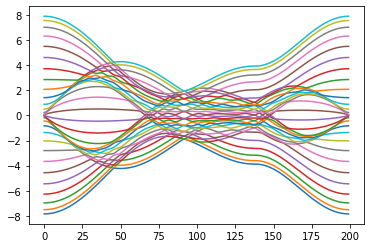

In [121]:
vals_up,vects_up = eigh(TBH + diag(X.x[:(N*2)]))
plot(vals_up)